### create figure for hierarchy example
1. get latent distances vs sequential distances
2. get MI of markov model
3. get MI of recursively generated sequence - store the average latent distance for each of the sequential distances
4. Plot latent distance by MI
5. plot sequential distance by MI

In [97]:
import numpy as np
import pandas as pd
from scipy import random as sr
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [98]:
def gen_balanced_matrix(na=5, ps=[0.7, 0.2, 0.1]):
    """ Generates a balanced matrix in which every state can reach every other state
    for hierarchical and Markov models
    """
    for r in range(1000):
        breakme = False
        probs = np.zeros((na, na))
        for p in ps:
            for i in np.arange(na):
                ixloc = np.where(
                    (probs[i, :] == 0) & (np.sum(probs != p, axis=0) == na)
                )[0]
                if len(ixloc) > 0:
                    probs[i, np.random.permutation(ixloc)[0]] = p
                else:
                    # the initialization didn't work
                    breakme = True
        if breakme:
            continue
        probs = probs / np.sum(probs, axis=0)
        return probs
    return "Generation Failed"

def gen_seq_hierarchical(alphabet, probs, depth, n_subsamples):
    """ generates a sequence via the Lin Tegmark recursive model
    Arguments:
        alphabet {[type]} -- [alphabet of states]
        probs {[type]} -- [probability matrix for recursive subsampling]
        depth {[type]} -- [how many times to recursively subsample]
        n_subsamples {[type]} -- [the number of new elements to recursively replace old elements with]
    
    Returns:
        sequence [type] -- [sequence of elements]
    """
    sequence = np.random.choice(
        alphabet, p=np.sum(probs, axis=1) / np.sum(probs), size=1
    )
    if type(depth) == list:
        depth = np.random.choice(depth)
    depth_list = range(depth)
    for i in tqdm(depth_list):
        q = np.random.choice(n_subsamples)
        sequence = subsample_sequence(sequence, probs, q, alphabet)
    return sequence


def subsample_sequence(sequence, probs, q, alphabet):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    return [
        item
        for sublist in [
            np.random.choice(alphabet, p=probs[:, i], size=q) for i in sequence
        ]
        for item in sublist
    ]

In [123]:
# how many branches to sample in hierarchical
n_subsamples = [2]
# how many subsamples to perform
depth = 18
# alphabet size
a_n = 15
alphabet = np.arange(a_n)
# how many sequences to use
nseq = 1
print('seq len ',(np.mean(n_subsamples)**depth))

seq len  262144.0


In [124]:
# generate probbility matrix 
probs = gen_balanced_matrix(na=a_n, ps=[.9, .1])

In [125]:
probs

array([[0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0.1, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0.1,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.9, 0. ,
        0. , 0. ],
       [0.9, 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0.1, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ,
        0.9, 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ,
       

In [126]:
# distances of MI to sample at
distances = np.arange(1,101)

In [127]:
sequences = gen_seq_hierarchical(alphabet, probs, depth, n_subsamples=n_subsamples)

In [128]:
len(sequences)

262144

In [129]:
sequences[:10]

[11, 11, 5, 5, 11, 11, 5, 5, 5, 11]

In [130]:
from childes_mi.information_theory import mutual_information as mi

In [131]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    [sequences], distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s


[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    1.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


In [132]:
MI_DF2 = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [ ]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

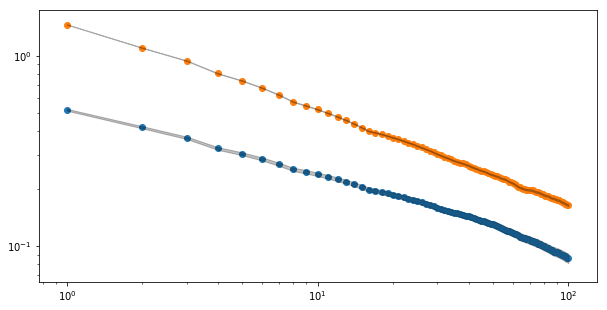

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
row = MI_DF.iloc[0]
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')

row = MI_DF2.iloc[0]
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')

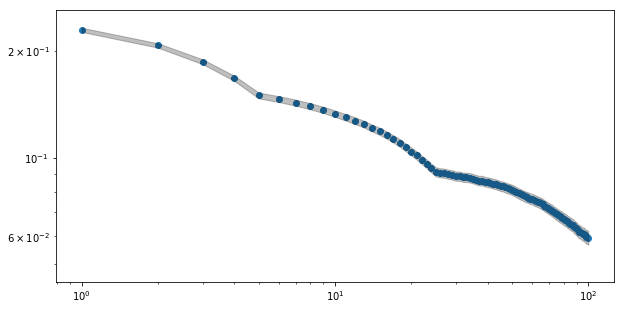

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')

In [28]:
latent_vs_sequential_distance = pd.read_pickle('latent_vs_sequential_distance.pickle')

In [16]:
latent_vs_sequential_distance[:3]

node1               node2             latent_distances  \
                       mean         std    mean         std             mean   
sequential_distance                                                            
1                    1535.0  295.458965  1534.0  295.458965         3.980450   
2                    1535.5  295.170290  1533.5  295.170290         5.964775   
3                    1536.0  294.881615  1533.0  294.881615         6.950049   

                               
                          std  
sequential_distance            
1                    2.759720  
2                    2.715128  
3                    2.856443

In [17]:
mean_latent_distances = latent_vs_sequential_distance.loc[distances].latent_distances['mean'].values

In [40]:
nplot = 100

In [41]:
np.max(mean_latent_distances[:nplot])

16.38095238095238

In [42]:
from matplotlib.ticker import StrMethodFormatter, NullFormatter

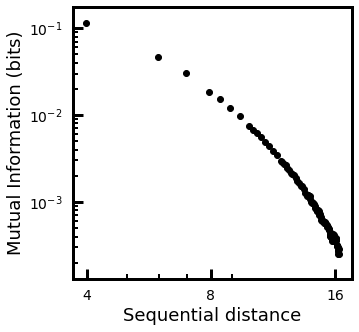

In [43]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
ax.scatter(mean_latent_distances[:nplot], MI[:nplot], color='k')
ax.fill_between(mean_latent_distances[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
#ax.plot(mean_latent_distances[:nplot], MI[:nplot], alpha = 1, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([1,50])

ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([4,8,16])
ax.set_xticklabels(['4','8','16'])

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())

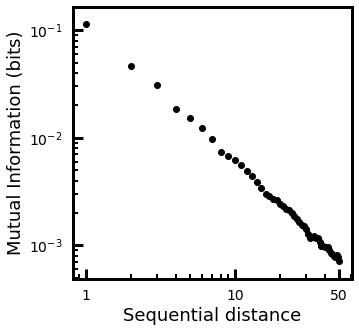

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
nplot=50
ax.scatter(distances[:nplot], MI[:nplot], color='k')
ax.fill_between(distances[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
#ax.plot(mean_latent_distances[:nplot], MI[:nplot], alpha = 1, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([1,50])

ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([1,10,50])
ax.set_xticklabels(['1','10','50'])

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())

#### fit decay

In [26]:
import lmfit

def residuals(y_true, y_model, x, logscaled=False):
    if logscaled:
        return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
    else:
        return np.abs(y_true - y_model)

def model_res(p, x, y, fit, model):
    if fit == "lin":
        return residuals(y, model(p, x), x)
    else:
        return residuals(y, model(p, x), x, logscaled=True)
    
# fitting model
def fit_model_iter(model, n_iter=10, **kwargs):
    """ re-fit model n_iter times and choose the best fit
    chooses method based upon best-fit
    """
    models = []
    AICs = []
    for iter in np.arange(n_iter):
        results_model = model.minimize(**kwargs)
        models.append(results_model)
        AICs.append(results_model.aic)
    return models[np.argmin(AICs)]

def get_y(model, results, x):
    return model({i: results.params[i].value for i in results.params}, x)

def exp_decay(p, x):
    return p["e_init"] * np.exp(-x * p["e_decay_const"]) + p["intercept"]

# decay types
def powerlaw_decay(p, x):
    return p["p_init"] * x ** (p["p_decay_const"]) + p["intercept"]

p_exp = lmfit.Parameters()
p_exp.add_many(
    ("e_init", 0.5, True, 1e-10),
    ("e_decay_const", 0.1, True, 1e-10),
    ("intercept", 1e-5, True, 1e-10),
)

p_power = lmfit.Parameters()
p_power.add_many(
    ("p_init", 0.5, True, 1e-10),
    ("p_decay_const", -0.5, True, -np.inf, -1e-10),
    ("intercept", 1e-5, True, 1e-10),
)

#### Fit exponential

In [54]:
fit='log'
n_iter=1
method=["nelder", "leastsq", "least-squares"]

In [55]:
d = mean_latent_distances[:nplot]
sig = MI[:nplot]

In [56]:
results_exp_min = lmfit.Minimizer(
    model_res, p_exp, fcn_args=(d, sig, fit, exp_decay), nan_policy="omit"
)

results_exp = [
    fit_model_iter(results_exp_min, n_iter=n_iter, **{"method": meth})
    for meth in method
]
results_exp = results_exp[np.argmin([i.aic for i in results_exp])]

results_exp

y_exp = get_y(exp_decay, results_exp, d)

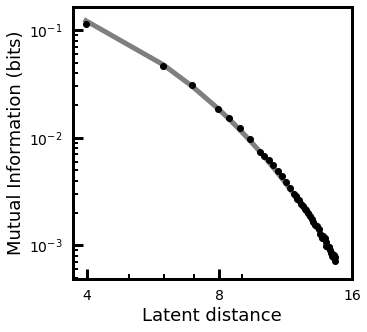

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
nplot=50
ax.scatter(mean_latent_distances[:nplot], MI[:nplot], color='k')
ax.fill_between(mean_latent_distances[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
ax.plot(mean_latent_distances[:nplot], y_exp, alpha = 0.5, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([1,50])

ax.set_xlabel('Latent distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([4,8,16])
ax.set_xticklabels(['4','8','16'])


ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())

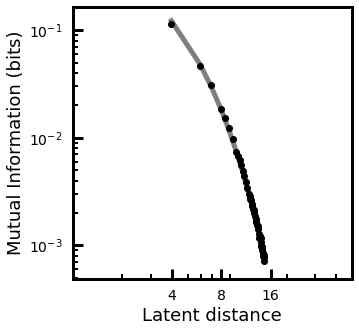

In [61]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
nplot=50
ax.scatter(mean_latent_distances[:nplot], MI[:nplot], color='k')
ax.fill_between(mean_latent_distances[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
ax.plot(mean_latent_distances[:nplot], y_exp, alpha = 0.5, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Latent distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([4,8,16])
ax.set_xticklabels(['4','8','16'])

ax.set_xlim([1,50])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())

#### Fit powerlaw

In [27]:
fit='log'
n_iter=1
method=["nelder", "leastsq", "least-squares"]

In [47]:
d = distances[:nplot]
sig = MI[:nplot]

In [48]:
results_power_min = lmfit.Minimizer(
    model_res,
    p_power,
    fcn_args=(d, sig, fit, powerlaw_decay),
    nan_policy="omit",
)

results_power = [
    fit_model_iter(results_power_min, n_iter=n_iter, **{"method": meth})
    for meth in method
]
results_power = results_power[np.argmin([i.aic for i in results_power])]

y_power = get_y(powerlaw_decay, results_power, d)

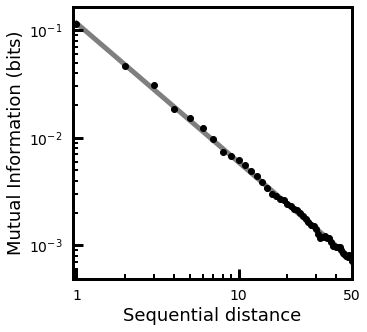

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
nplot=50
ax.scatter(d[:nplot], MI[:nplot], color='k')
ax.fill_between(d[:nplot], MI[:nplot]-MI_var[:nplot], MI[:nplot]+MI_var[:nplot], alpha = 0, color= 'k')
ax.plot(d[:nplot], y_power, alpha = 0.5, color= 'k', lw=5)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([1,50])

ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Mutual Information (bits)', fontsize=18)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

ax.set_xticks([1,10,50])
ax.set_xticklabels(['4','8','50'])
ax.set_xlim([0.95,50])

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())